# Policy

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Both regimes, all shocks](#toc2_)    
- 3. [Foreign vs. domestic - AR(1)](#toc3_)    
- 4. [ReR and ToT](#toc4_)    
- 5. [Tables](#toc5_)    
  - 5.1. [Consumption](#toc5_1_)    
  - 5.2. [Income](#toc5_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["NUMBA_PARFOR_MAX_TUPLE_SIZE"] = "200"
from copy import deepcopy
from IPython.display import display

import numpy as np
import pandas as pd
import numba as nb
nb.set_num_threads(4)
from scipy import optimize

import matplotlib.pyplot as plt

import figs
from IHANKModel import HANKModelClass

In [2]:
regimes = ['floating','fixed']
skip = []

labelsdict = {
    'ForeignDemand':r'LP',
    'eps_beta':r'Domestic demand, $\beta$',
    'UniformT_exo':r'$T$',
    'G_exo':r'$G$',
    'di':r'$i$',
    'ND':r'ND',
    'FD':r'FD',
}

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [3]:
model_float = HANKModelClass('HANK')
model_float.load_data()

In [4]:
model_float.load_est_par(f'HANK_est_par_best',do_print=True)
model_float.load_x0s(f'HANK_x0s')

NKslope__T = 0.0745 [now: nan]
NKslope_NT = 0.0679 [now: nan]
NKWslope__T = 0.0493 [now: nan]
NKWslope_NT = 0.0005 [now: nan]
pi_index = 0.6595 [now: nan]
piW_index = 0.8136 [now: 0.0000]
phi = 1.3421 [now: nan]
phi_back = 0.1411 [now: nan]
phi_N = 1.7901 [now: nan]
phi_I = 5.5788 [now: nan]
kappa_r = 0.2890 [now: nan]
UIP_dev = 1.1098 [now: nan]
gamma = 2.9760 [now: nan]
phi_X = 0.7825 [now: nan]


In [5]:
model_float.find_ss()

In [6]:
model_float.compute_jacs(skip_shocks=True)

In [7]:
model_fixed = model_float.copy()
model_fixed.par.floating = False
model_fixed.compute_jacs(skip_shocks=True,skip_hh=True)

## 2. <a id='toc2_'></a>[Both regimes, all shocks](#toc0_)

In [8]:
class StopIteration(Exception): pass 
def ND_FD_res(x,model_FD,model_ND):

    print(f'  subI_weight = subP_weight = {x:.4f}',end='')
    
    model_FD.par.FD_shock = True
    model_FD.par.VAT_weight = 1.
    model_FD.par.subI_weight = x
    model_FD.par.subP_weight = x 

    shockvalues = 0.0001*0.8**np.arange(model_FD.par.T)

    model_FD.find_transition_path(shocks={f'dFD':shockvalues},do_end_check=False)
    model_FD.scaleshock('C',size=0.01,cumeffect=True,Nq=20)

    IRF_ND = (model_ND.path.ToT[0,0]-model_ND.ss.ToT)/model_ND.ss.ToT*model_ND.par.scale*100
    IRF_FD = (model_FD.path.ToT[0,0]-model_FD.ss.ToT)/model_ND.ss.ToT*model_FD.par.scale*100
    error = IRF_ND-IRF_FD
    
    print(f' -> {error:12.8f}')
    if np.abs(error) < 1e-4:
        raise StopIteration

    return error

def calib_and_run_FD(model_FD,model_ND):    

    try:
        result = optimize.root_scalar(ND_FD_res,bracket=(1.0,2.0),args=(model_FD,model_ND),method='brentq')    
        ND_FD_res(result.root,model_FD,model_ND)
    except StopIteration:
        pass


In [9]:
shocklists = {
    'floating':['ForeignDemand', 'eps_beta', 'UniformT_exo', 'G_exo','di'],
    'fixed':['ForeignDemand', 'eps_beta', 'UniformT_exo', 'G_exo','ND','FD'],
}

models = {}
for regime in regimes:

    print(regime)
    models[regime] = {}

    if regime == 'floating':
        model = model_float
    else:
        model = model_fixed

    for i,shock in enumerate(shocklists[regime]):

        if shock in skip: continue
        
        print(f' {shock}')
        models[shock] = {}
        
        if shock == 'FD':

            model.use_FD_shock(True)
            calib_and_run_FD(model,models[regime]['ND'])

        elif shock == 'ForeignDemand':
        
            model.find_transition_path_foreign_shock(do_print=False)
        
        else:

            shockvalues = 0.00001*0.8**np.arange(model.par.T)
            model.find_transition_path(shocks={f'd{shock}':shockvalues},do_end_check=False)
        
        if shock == 'ForeignDemand' or shock == 'eps_beta':
            model.scaleshock('C', size=-0.01, cumeffect=True, Nq=20)
        else:
            model.scaleshock('C',  size=0.01, cumeffect=True, Nq=20)

        models[regime][shock] = deepcopy(model)
        if not shock == 'ND': models[regime][shock].compress_full()  

    print('')    

floating
 ForeignDemand


 eps_beta


 UniformT_exo


 G_exo


 di



fixed
 ForeignDemand


 eps_beta


 UniformT_exo


 G_exo


 ND


 FD
  subI_weight = subP_weight = 1.0000

 ->  -0.53174188
  subI_weight = subP_weight = 2.0000

 ->   1.04069584
  subI_weight = subP_weight = 1.3382

 ->   0.80830570
  subI_weight = subP_weight = 1.1342

 ->   0.46863353
  subI_weight = subP_weight = 1.0713

 ->   0.19827850
  subI_weight = subP_weight = 1.0377

 ->  -0.04931748
  subI_weight = subP_weight = 1.0444

 ->   0.00936042
  subI_weight = subP_weight = 1.0434

 ->   0.00037422
  subI_weight = subP_weight = 1.0433

 ->  -0.00000012


## 3. <a id='toc3_'></a>[Foreign vs. domestic - AR(1)](#toc0_)

regime = floating


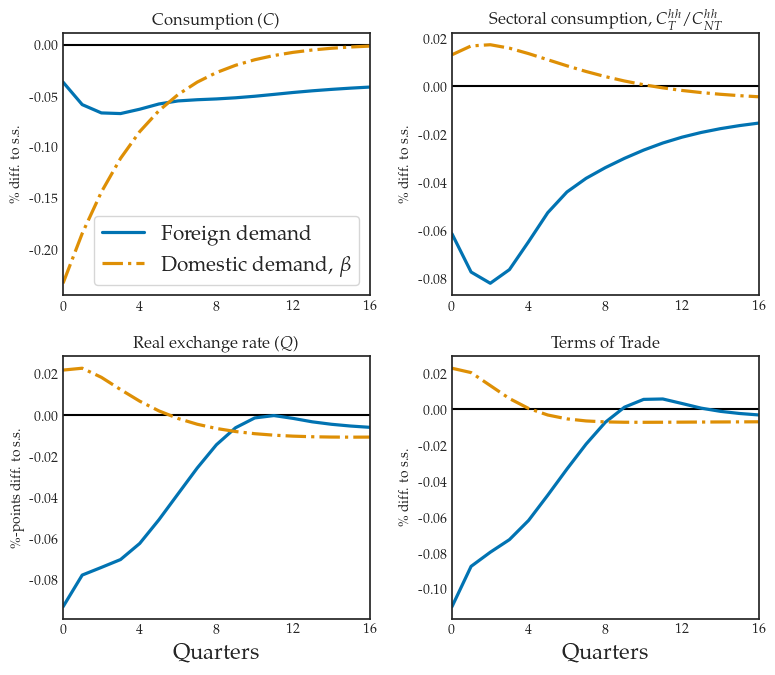

regime = fixed


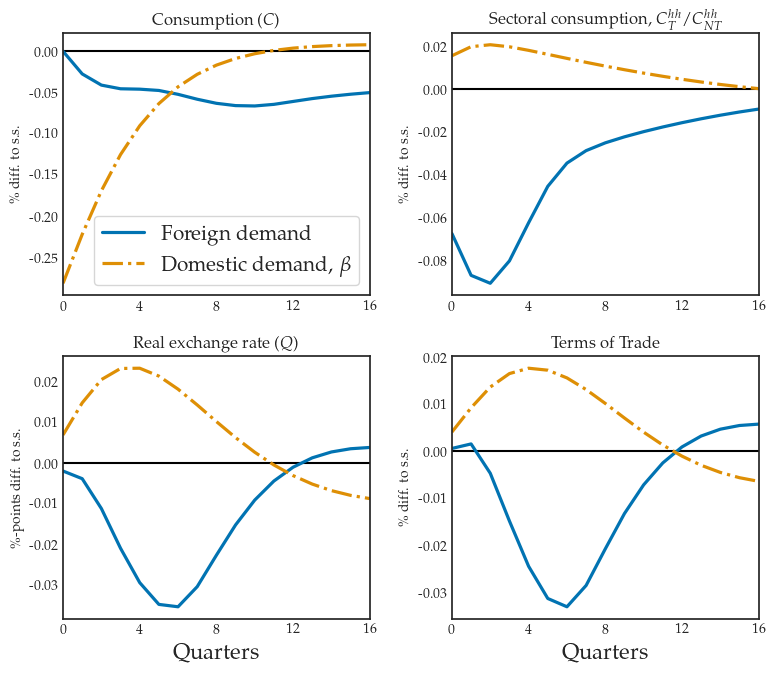

In [10]:
paths_foreign_vs_domest = ['C','rel_C_hh','Q','ToT']
lstyles = ['-', '-.', '--', (0, (3, 1, 1, 1)), ':']
colors = ['C0', 'C1', 'C2', 'C3', 'black']

for regime in regimes:

    print(f'regime = {regime}')
 
    models_ = [models[regime][shock] for shock in ['ForeignDemand','eps_beta'] if shock not in skip]   
    if len(models_) == 0: continue
    labels = [labelsdict[shock] for shock in ['ForeignDemand','eps_beta'] if shock not in skip] 

    for model in models_:

        model.path.rel_C_hh = model.path.C_T_hh/model.path.C_NT_hh
        model.ss.rel_C_hh = model.ss.C_T_hh/model.ss.C_NT_hh
        
        model.path.rel_wn_hh = model.path.wnT/model.path.wnNT
        model.ss.rel_wn_hh  = model.ss.wnT/model.ss.wnNT

    fig = figs.show_IRFs(models=models_,paths=paths_foreign_vs_domest,labels=['Foreign demand',labels[1]],
                              lstyles=lstyles,colors=colors,lwidth=2.3,palette='colorblind',
                              maxcol=2,figsize=[4,3.5],legend_window=0)  

    fig.savefig(f'plots/policy_foreign_vs_domestic_{regime}.pdf')


## 4. <a id='toc4_'></a>[ReR and ToT](#toc0_)

In [11]:
'UniformT_exo', 'G_exo','ND','FD'

('UniformT_exo', 'G_exo', 'ND', 'FD')

regime = floating


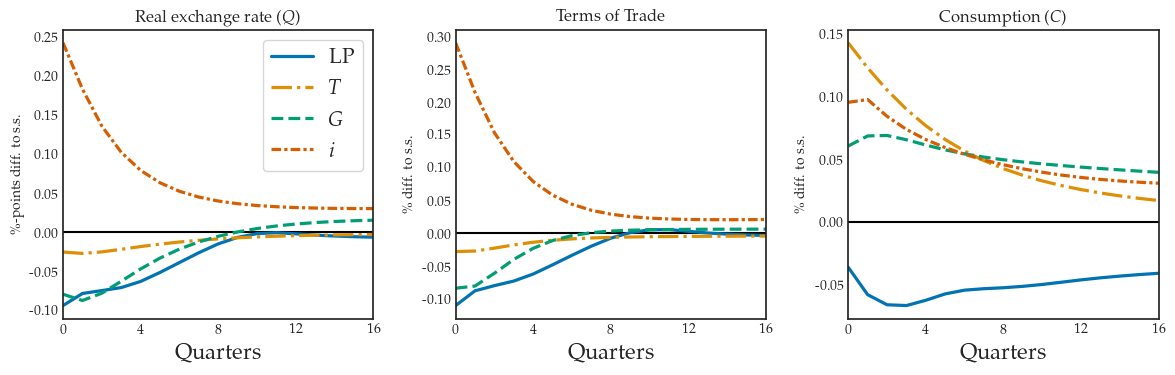

regime = fixed


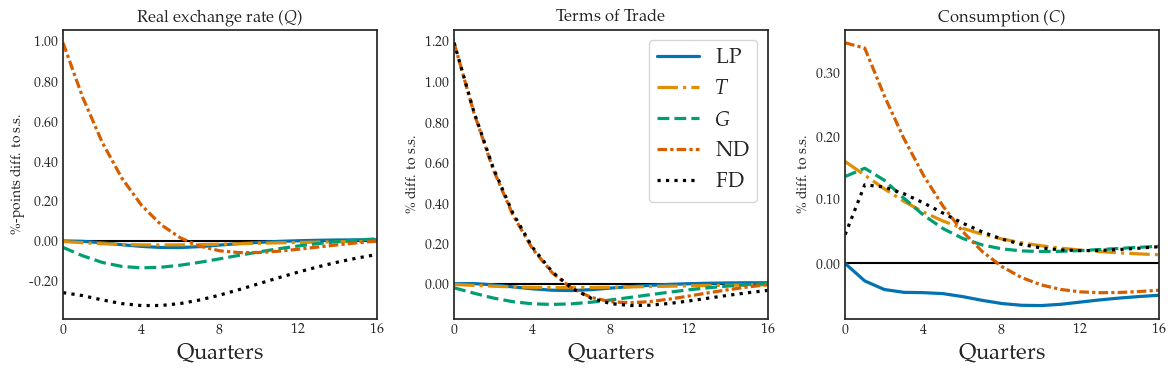

In [12]:
paths_Q_ToT = ['Q','ToT','C']
lstyles = ['-', '-.', '--', (0, (3, 1, 1, 1)), ':']
colors = ['C0', 'C1', 'C2', 'C3', 'black']

for regime in regimes:

    print(f'regime = {regime}')
 
    models_ = [models[regime][shock] for shock in shocklists[regime] if shock != 'eps_beta' and shock not in skip]   
    if len(models_) == 0: continue
    labels = [labelsdict[shock] for shock in shocklists[regime] if shock != 'eps_beta' and shock not in skip] 

    if regime == 'floating':
        legend_window = 0
    else:
        legend_window = 1

    fig = figs.show_IRFs(models=models_,paths=paths_Q_ToT,labels=labels,
                              lstyles=lstyles,colors=colors,lwidth=2.3,palette='colorblind',
                              maxcol=3,figsize=[4,4],legend_window=legend_window)  

    fig.savefig(f'plots/policy_Q_ToT_{regime}.pdf')


## 5. <a id='toc5_'></a>[Tables](#toc0_)

In [13]:
def CumMult(model,var,r=0,T=20,sign=1):

    scale = model.par.scale 
    if np.isclose(getattr(model.ss,var),0):
        dX = (getattr(model.path,var) - getattr(model.ss,var))*scale
    else:
        dX = (getattr(model.path,var) - getattr(model.ss,var))*scale/getattr(model.ss,var)
        
    return 100*np.sum(dX[:T]) 

In [14]:
def write_table(models,TNT_vars=['C_T_hh','C_NT_hh'],precision=2,postfix='cons'):
    
    shock_descs = {
        'ForeignDemand':r'Foreign demand, $\beta^*$', 
        'eps_beta':r'Domestic demand, $\beta$',  
        'UniformT_exo':'Public transfers, $T$',
        'G_exo':'Public spending, $G$', 
        'di':'Monetary policy, $i$', 
        'ND':'Nominal devaluation', 
        'FD':'Fiscal devaluation'
    }     
    
    shock_descs_ = {}
    for shock in shock_descs:
        shock_descs_[shock] = {}
        shock_descs_[shock]['name'] =  shock_descs[shock]
    
    sign=1
    hori = 20 
    content = {}
    for regime in regimes: 
        content[regime] = {}
        for shock in models[regime]:
            content[regime][shock] = {}
            content[regime][shock]['C'] = CumMult(models[regime][shock],'C', T=hori,sign=sign)
            content[regime][shock][TNT_vars[0]] = CumMult(models[regime][shock],TNT_vars[0], T=hori,sign=sign)
            content[regime][shock][TNT_vars[1]] = CumMult(models[regime][shock],TNT_vars[1], T=hori,sign=sign)
            a =  CumMult(models[regime][shock],TNT_vars[0], T=hori,sign=sign)
            b = CumMult(models[regime][shock],TNT_vars[1], T=hori,sign=sign)
            content[regime][shock]['CT_2_CNT'] =a/b

    df = pd.concat([
        pd.DataFrame(shock_descs_), 
        pd.DataFrame(content['floating']),
        pd.DataFrame(content['fixed'])],axis=0)

    df = df.replace(np.NaN, '-')

    df_text = df.T.style.hide(axis='index').format(precision=precision)
    display(df_text)

    if not postfix is None:

        txt = df_text.to_latex()
        i = txt.find('Foreign demand')
        j = txt.find('\end{tabular}')

        with open(f'tables/policy_tabel_main_{postfix}.txt','w') as text_file:
            text_file.write(txt[i:j])


### 5.1. <a id='toc5_1_'></a>[Consumption](#toc0_)

In [15]:
write_table(models,TNT_vars=['C_T_hh','C_NT_hh'],postfix='cons')

name,C,C_T_hh,C_NT_hh,CT_2_CNT,C,C_T_hh,C_NT_hh,CT_2_CNT
"Foreign demand, $\beta^*$",-1.00,-1.42,-0.68,2.10,-1.00,-1.38,-0.71,1.94
"Domestic demand, $\beta$",-1.00,-0.96,-1.03,0.93,-1.00,-0.90,-1.08,0.83
"Public transfers, $T$",1.00,0.60,1.31,0.46,1.00,0.57,1.33,0.43
"Public spending, $G$",1.00,0.55,1.34,0.41,1.00,-0.01,1.78,-0.01
"Monetary policy, $i$",1.00,1.49,0.62,2.39,-,-,-,-
Nominal devaluation,-,-,-,-,1.00,2.02,0.22,9.38
Fiscal devaluation,-,-,-,-,1.00,1.94,0.28,6.89


### 5.2. <a id='toc5_2_'></a>[Income](#toc0_)

In [16]:
write_table(models,TNT_vars=['wnT', 'wnNT'],postfix='income')

name,C,wnT,wnNT,CT_2_CNT,C,wnT,wnNT,CT_2_CNT
"Foreign demand, $\beta^*$",-1.00,-2.08,-0.89,2.34,-1.00,-2.00,-0.91,2.18
"Domestic demand, $\beta$",-1.00,-0.31,-0.47,0.67,-1.00,-0.09,-0.41,0.22
"Public transfers, $T$",1.00,0.05,0.46,0.10,1.00,-0.00,0.45,-0.01
"Public spending, $G$",1.00,0.62,1.97,0.32,1.00,0.07,3.04,0.02
"Monetary policy, $i$",1.00,2.18,0.81,2.67,-,-,-,-
Nominal devaluation,-,-,-,-,1.00,4.01,1.07,3.74
Fiscal devaluation,-,-,-,-,1.00,4.18,1.49,2.81
